In [4]:
!pip install -q biopython
!pip install Bio
!pip install -q ReportLab
#gseapy
!pip install -q gseapy

In [4]:
import gseapy as gp
from gseapy import barplot, dotplot
import pickle
import pandas as pd

XGBoost returns a list with the most important features to predict the condition of the cell. A common double-check done in bioinformatics is to check if this set of genes is involved in some biological path, or if these genes are just together "by chance".

To check this, you usually test your group against a dataset of set of genes well known for their function in some biological path. Checking how much our genes are over (or under) represented with respect to a set of genes in a specific biological path, we can compute an adjusted p-value, that will give us an idea of how sure we are that our set is linked to that pathway. 

To do so, we define:
* Our genes list, that is basically our set of significant genes for predicting the condition of Hypoxia or Normoxia. As we said before, this is the list of relevant genes returned by XGBoost.
* A list of sets of genes, well known for being involved in biological paths. We choose as dataset for these sets the MSigDB_Hallmark_2020, since it's well recognized in literature, and it was shown in class.

The adjusted p-values will be computed over over these two lists, using a default dest given by the function gp.enrich, that is .....

In [10]:
# load the xgboost dropseq model and return the list of the 50 most important genes
filename = '/Users/filipporonzino/Downloads/dropseq_merged dataset'
with open(filename, 'rb') as f:
    xgboost_dropseq = pickle.load(f)['model']
feature_importance = xgboost_dropseq.feature_importances_
feature_names = xgboost_dropseq.get_booster().feature_names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_50_genes = feature_importance_df['Feature'][:50].tolist()
# Print the top 50 genes
print("Top 50 Genes:", top_50_genes)

Top 50 Genes: ['NDRG1', 'FGF23', 'IGFBP3', 'AKR1C1', 'BNIP3', 'LDHA', 'GPM6A', 'WDR43', 'NPM1P40', 'AKR1C2', 'EIF3J', 'HSPD1', 'EGLN3', 'P4HA1', 'PGK1', 'RPL41', 'NCALD', 'TMSB10', 'KRT19', 'BTBD9', 'BNIP3L', 'MT-TQ', 'MT-TV', 'MT1X', 'BCYRN1', 'S100A10', 'B4GALT1', 'HSP90AA1', 'NCL', 'AHNAK2', 'CNNM2', 'C4orf3', 'ZNF302', 'CALM2', 'CACNA1A', 'NEAT1', 'MT1E', 'ENO1', 'GBP1P1', 'RPS29', 'H4C5', 'RPS21', 'FOXP1', 'RPS28', 'MALAT1', 'PRRG3', 'S100A6', 'PLOD2', 'RPS27', 'HSP90AB1']


In [19]:
gene_list = top_50_genes
gene_sets = ['MSigDB_Hallmark_2020'] # selected as it was shown in class
gene_background = None

In [20]:
enr = gp.enrichr(gene_list=gene_list, 
                 gene_sets=gene_sets, 
                 organism='human', 
                 background=gene_background,
                 outdir=None, 
                )

In [21]:
enrichment_results_df = enr.results
enrichment_results_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Hypoxia,8/200,3.255912e-08,4.069890e-07,0,0,19.601190,337.928605,BNIP3L;LDHA;P4HA1;IGFBP3;PGK1;ENO1;NDRG1;MT1E
1,MSigDB_Hallmark_2020,Glycolysis,8/200,3.255912e-08,4.069890e-07,0,0,19.601190,337.928605,LDHA;EGLN3;B4GALT1;P4HA1;IGFBP3;PGK1;PLOD2;ENO1
2,MSigDB_Hallmark_2020,mTORC1 Signaling,7/200,6.247575e-07,5.206313e-06,0,0,16.664538,238.067958,LDHA;EGLN3;P4HA1;PGK1;PLOD2;ENO1;HSPD1
3,MSigDB_Hallmark_2020,Myc Targets V1,5/200,1.398365e-04,8.739782e-04,0,0,11.256410,99.901053,LDHA;HSP90AB1;EIF3J;PGK1;HSPD1
4,MSigDB_Hallmark_2020,Androgen Response,3/100,2.004676e-03,1.002338e-02,0,0,13.064049,81.157437,KRT19;B4GALT1;NDRG1


/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


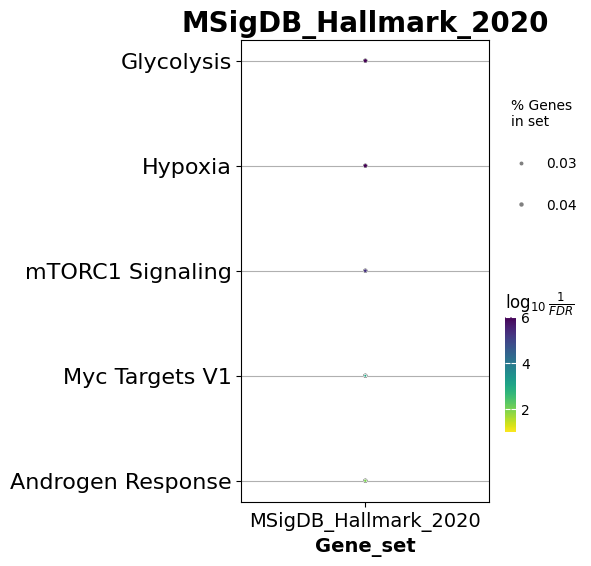

In [22]:
#Show top 5 terms of each gene_set ranked by “Adjusted P-value”
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(4,6),
              title = "MSigDB_Hallmark_2020", 
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

 We immediately see that the gene sets that are over-represented are the ones corresponding to: Hypoxia. This is of course to be expected, since we have used as our gene list the genes that are relevant for classification of hypoxia.

It is moreover clear that in <code>enr.results</code>, the highest overlap is the one for Hypoxia, which means that the number of genes that overlap between our gene list and the genes in the specific gene set chosen is 18/200

